# Introdução a análise e gerenciamento de dados em Python

Vamos exemplificar aqui a análise de dados de uma série de poços extraídos do SIAGAS. Nosso objetivo final é __obter uma coleção de superfícies de poços para Chapecó, no oeste do estado__.

Realizaremos as seguintes atividades nesse trajeto:
1. Importar os dados de um arquivo xlsx;
2. Analisar, filtrar e organizar os dados para formação de matrizes de pontos;
3. Formar matrizes de pontos para cada tipo litológico, triangularizar e gerar uma superfície em 3D;

## Primeiro vamos importar as bibliotecas

- <span style='color: blue'>pandas</span>: Irá nos ajudar a gerenciar e analisar os dados
- <span style='color: blue'>numpy</span>: Também nos ajudar a gerenciar e analisar os dados
- <span style='color: blue'>seaborn</span>: Biblioteca que utiliza o Matplotlib e fornecerá os gráficos necessários para analisar os dados
- <span style='color: blue'>geopandas</span>: Para trabalhar com dados vetorizados georeferenciados
- <span style='color: blue'>pyplot de matplotlib</span>: Módulo de plotagem do matplotlib
- <span style='color: blue'>pyvista</span>: Para adicionar os pontos ao nosso projeto
- <span style='color: blue'>view de itkwidgets</span>: Para representarmos as camadas litológicas triangularizadas
- <span style='color: blue'>Point de Shapely</span>: Para adicionar os pontos ao nosso projeto

In [2]:
import pandas as pd
import numpy as np
import seaborn as sn
import geopandas as gp
import matplotlib.pyplot as plt
import pyvista as pv
from itkwidgets import view
from shapely.geometry import Point

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


Vamos definir funções que nos ajudarão no processo de análise:

In [2]:
def agruparLitologias( df ):
    """
    Agrupa litologias para que tenham um 'de' 'ate' em uma só linha.
    
    Entrada:
            df: DataFrame contendo as colunas 'nome', 'litologia', 'de', 'ate'
    Retora:
            DataFrame formatado.
    """
    
    assert( type(df) == pd.DataFrame)
    
    df_final = pd.DataFrame( columns = df.columns )
    nomes = set(df['nome'])
    
    for nome in nomes:
        tmp_df = df[ df['nome'] == nome ]
        litologias = dict(tmp_df['litologia'].value_counts())
        
        for litologia, quantidade in litologias.items():
            df_lit = tmp_df[ tmp_df['litologia'] == litologia ]
            if quantidade > 1:
                de_min = df_lit['de'].min()
                ate_max = df_lit['ate'].max()
                
                df_lit = df_lit.iloc[0]
                df_lit['de'] = de_min
                df_lit['ate'] = ate_max
                
            df_final = df_final.append( df_lit )
            
    return df_final

Agora importaremos os dados obtidos do SIAGAS em nossa planilha.

Como primeiro passo importaremos nossa planilha e selecionaremos os dados para trabalharmos com ele. Faremos isso usando o método **read_excel** do pandas.

Por padrão, a função **read_excel** lê apenas a primeira planilha de um arquivo. Nós iremos precisar de dados de duas planilhas, a que contém dados gerais e a que contém informações de litologia. Para acionar a leitura de todos as abas, atribuiremos ao atributo **sheet_name** o valor <code>None</code>. Logo em seguida, filtraremos as planilhas que desejamos utilizar.

In [3]:
#Chamaremos nossa variável de "df" de DataFrame.

df = pd.read_excel('./training/dataset.xlsx', sheet_name=None)

df_gerais = df['Dados_Gerais']
df_litologia = df['Litologia']

Vamos dar uma olhada em cada uma de nossas planilhas e checar como estão:

### Dados Gerais:

In [4]:
df_gerais.head()

,nome,cod_siagas,data_da_instalacao,proprietario,natureza_ponto,uso_da_agua,cota_do_terreno,localidade,utm_ns,utm_lo,latitude,longitude,bacia_hidrografica,subbacia_hidrografica,data_registro_situacao,situacao,resp_cadastro,fonte_dados,comentarios
0,SN_nan_4300003347,4300003347,13/08/1984,NaN,Poço tubular,Abastecimento urbano,340.0,LINHA PASSO DA UVA,6983841,367615,271543,522014,Rio Uruguai,"Rios Uruguai, Chapeco e outros",15/10/2005,Bombeando,WST,SIAGAS,NaN
1,SN_nan_4300003348,4300003348,28/05/1998,NaN,Poço tubular,Abastecimento doméstico,324.0,LINHA PASSO DO UVA,6983796,367796,271544,522008,Rio Uruguai,"Rios Uruguai, Chapeco e outros",15/06/1998,Equipado,WST,SIAGAS,NaN
2,SN_nan_4300003349,4300003349,14/03/1994,NaN,Poço tubular,Abastecimento doméstico/animal,393.0,LINHA PASSO DO UVA,6983377,368693,271558,521935,Rio Uruguai,"Rios Uruguai, Chapeco e outros",15/10/2005,Abandonado,WST,SIAGAS,NaN
3,SN_nan_4300003350,4300003350,29/05/1998,NaN,Poço tubular,Abastecimento doméstico/animal,360.0,LINHA ALTO BORBOLETA,6987118,365730,271356,522122,Rio Uruguai,"Rios Uruguai, Chapeco e outros",13/10/2005,Bombeando,WST,SIAGAS,NaN
4,SN_nan_4300003351,4300003351,26/07/1994,NaN,Poço tubular,NaN,500.0,LINHA PINDORAMA,6987450,362900,271343,522304,Rio Uruguai,"Rios Uruguai, Chapeco e outros",15/06/1998,Seco,WST,SIAGAS,NaN


In [5]:
shape_gerais = df_gerais.shape
print(f'A planilha de dados gerais possui {shape_gerais[0]} linhas e {shape_gerais[1]} colunas.')

A planilha de dados gerais possui 1185 linhas e 19 colunas.


### Litologias:

In [6]:
df_litologia.head()

,nome,de,ate,litologia,descricao,fonte_dados,resp_cadastro,comentarios
0,SN_nan_4300003347,0.0,8.0,Solo argiloso,SOLO ARGILOSO.,SIAGAS,WST,NaN
1,SN_nan_4300003347,8.0,15.0,Basalto,BASALTO CINZA,SIAGAS,WST,NaN
2,SN_nan_4300003347,15.0,54.0,Basalto,BASALTO CINZA INALTERADO.,SIAGAS,WST,NaN
3,SN_nan_4300003347,54.0,66.0,Basalto,BASALTO CASTANHO POUCO AL-TERADO.,SIAGAS,WST,NaN
4,SN_nan_4300003347,66.0,73.0,Basalto,BASALTO CINZA SAO.,SIAGAS,WST,NaN


In [7]:
shape_litologia = df_litologia.shape
print(f'A planilha de litologias possui {shape_litologia[0]} linhas e {shape_litologia[1]} colunas.')

A planilha de litologias possui 2837 linhas e 8 colunas.


Para nosso objetivo é interessante possuirmos a latitude, longitude e cota dos poços. Podemos observar que só temos essas informações nos dados gerais.

Vamos, então, adicionar essas informações nos dados de litologia. Para fazer isso, precisamos criar uma estrutura de dados chamada __dicionário__, que nos ajuda a indicar um valor a partir de uma chave. No contexto da linguagem Python, a sintaxe de diconário é essa:

```python
exemplo = {
    'chave1' : 'valor1',
    'chave2' : 'valor2',
    'chave3' : 'valor3'
}
```

Em nosso código, precisamos criar pares de tuplas (outra forma de estruturar dados) para então convertê-las em dicionário. Utilizaremos o método <code>zip</code> para tornar duas listas de mesmo comprimento em uma lista de tuplas com dois elemento. O dicionário necessita de uma chave única para cada valor. Como temos certeza de que os dados da planilha de dados gerais não possui duplicatas, não precisaremos fazer esse tratamento.

In [8]:
#Vamos criar uma estrutura de dicionário contendo uma relação de nomes-utm_ns e nomes-utm_lo
dict_ns = dict(zip(df_gerais['nome'],df_gerais['utm_ns']))
dict_lo = dict(zip(df_gerais['nome'],df_gerais['utm_lo']))
dict_cota = dict(zip(df_gerais['nome'],df_gerais['cota_do_terreno']))

#Coordenadas Norte-Sul
df_litologia['utm_ns'] = df_litologia['nome'].map(dict_ns)
df_litologia['utm_lo'] = df_litologia['nome'].map(dict_lo)
df_litologia['cota_do_terreno'] = df_litologia['nome'].map(dict_cota)

Vamos agora checar como está nosso _dataframe_ de litologia:

In [9]:
df_litologia.head()

,nome,de,ate,litologia,descricao,fonte_dados,resp_cadastro,comentarios,utm_ns,utm_lo,cota_do_terreno
0,SN_nan_4300003347,0.0,8.0,Solo argiloso,SOLO ARGILOSO.,SIAGAS,WST,NaN,6983841,367615,340.0
1,SN_nan_4300003347,8.0,15.0,Basalto,BASALTO CINZA,SIAGAS,WST,NaN,6983841,367615,340.0
2,SN_nan_4300003347,15.0,54.0,Basalto,BASALTO CINZA INALTERADO.,SIAGAS,WST,NaN,6983841,367615,340.0
3,SN_nan_4300003347,54.0,66.0,Basalto,BASALTO CASTANHO POUCO AL-TERADO.,SIAGAS,WST,NaN,6983841,367615,340.0
4,SN_nan_4300003347,66.0,73.0,Basalto,BASALTO CINZA SAO.,SIAGAS,WST,NaN,6983841,367615,340.0


Podemos observar que a nossa litologia possui elementos repetidos para um mesmo nome de poço!

É interessante para nós termos valores únicos para cada camada litológica descrita. Vamos, portanto, utilizar a função declarada lá no início para agrupar as litologias.

In [10]:
df_litologia = agruparLitologias( df_litologia )
df_litologia

,nome,de,ate,litologia,descricao,fonte_dados,resp_cadastro,comentarios,utm_ns,utm_lo,cota_do_terreno
1761,SN_nan_4300015619,0.0,186.0,Basalto,Basalto,SIAGAS,WST,NaN,7010189,344574,504.0
746,SN_nan_4300004878,0.0,128.0,Basalto,BASALTO,SIAGAS,WST,NaN,7019845,305660,335.0
1585,SN_nan_4300012884,1.0,102.0,Basalto,"BASALTO CINZA CLARO, INALTERADO MACICO.",SIAGAS,WST,NaN,7019808,308525,325.0
1584,SN_nan_4300012884,0.0,1.0,Solo,Solo,SIAGAS,WST,NaN,7019808,308525,325.0
138,SN_NORTE GAS BUTANO DISTR. LTDA_4300003933,0.0,100.0,Basalto,BASALTO,SIAGAS,WST,NaN,7007965,369693,589.0
...,...,...,...,...,...,...,...,...,...,...,...
1001,SN_nan_4300010947,0.0,182.0,Basalto,Basalto cinza,SIAGAS,WST,NaN,6987252,333413,587.0
573,SN_nan_4300004644,0.0,0.1,Basalto,Basalto,SIAGAS,WST,NaN,7013711,340676,710.0
219,SN_nan_4300004151,0.0,72.0,Basalto,BASALTO CINZA cinza,SIAGAS,WST,NaN,6995688,366339,540.0
211,SN_nan_4300004145,4.0,84.0,Basalto,BASALTO ALTERADO MOLE,SIAGAS,WST,NaN,6995446,366660,670.0


Feito isso, iremos manter somente as colunas que iremos utilizar em nosso _dataset_:

- nome
- de
- ate
- litologia
- latitude
- longitude
- cota_do_terreno

In [11]:
#df_litologia = df_litologia.drop(['descricao', 'fonte_dados','resp_cadastro', 'comentarios'], axis=1)

In [12]:
df_litologia.head()

,nome,de,ate,litologia,utm_ns,utm_lo,cota_do_terreno
1761,SN_nan_4300015619,0.0,186.0,Basalto,7010189,344574,504.0
746,SN_nan_4300004878,0.0,128.0,Basalto,7019845,305660,335.0
1585,SN_nan_4300012884,1.0,102.0,Basalto,7019808,308525,325.0
1584,SN_nan_4300012884,0.0,1.0,Solo,7019808,308525,325.0
138,SN_NORTE GAS BUTANO DISTR. LTDA_4300003933,0.0,100.0,Basalto,7007965,369693,589.0


Perfeito, temos a planilha configurada para começarmos a analizar os dados. Primeiro vamos checar se há dados faltantes nos campos.

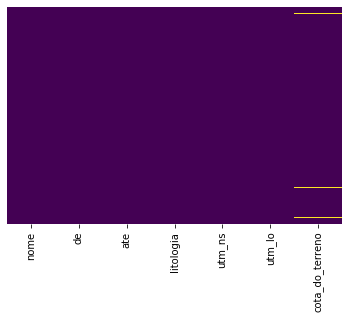

In [13]:
sn.heatmap(df_litologia.isnull(), cmap='viridis', yticklabels=False, cbar=False)

É possível notar que existem dados que não possuem cota de terreno. Nesse caso, é interessante removermos de nossa análise.

In [14]:
df_litologia = df_litologia[ ~df_litologia['cota_do_terreno'].isnull() ]
df_litologia.head()

,nome,de,ate,litologia,utm_ns,utm_lo,cota_do_terreno
1761,SN_nan_4300015619,0.0,186.0,Basalto,7010189,344574,504.0
746,SN_nan_4300004878,0.0,128.0,Basalto,7019845,305660,335.0
1585,SN_nan_4300012884,1.0,102.0,Basalto,7019808,308525,325.0
1584,SN_nan_4300012884,0.0,1.0,Solo,7019808,308525,325.0
138,SN_NORTE GAS BUTANO DISTR. LTDA_4300003933,0.0,100.0,Basalto,7007965,369693,589.0


Vamos verificar se a operação ocorreu como o esperado:

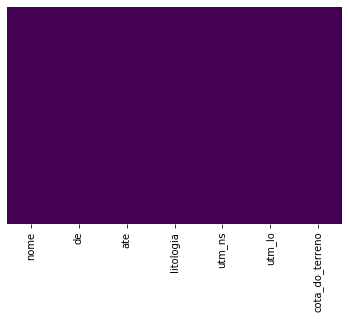

In [15]:
sn.heatmap(df_litologia.isnull(), cmap='viridis', yticklabels=False, cbar=False)

Perfeito, não possuímos mais dados sem valores. Agora vamos verificar a distribuição dos valores de cotas.

Os poços foram extraídos da região de Chapecó e entornos. Vamos verificar a distribuição espacial e de valores.

In [16]:
# Certificando que os valores estarão armazenados como sendo floats
df_litologia['utm_ns'] = df_litologia['utm_ns'].astype('float')
df_litologia['utm_lo'] = df_litologia['utm_lo'].astype('float')
df_litologia['cota_do_terreno'] = df_litologia['cota_do_terreno'].astype('float')

### Cotas:

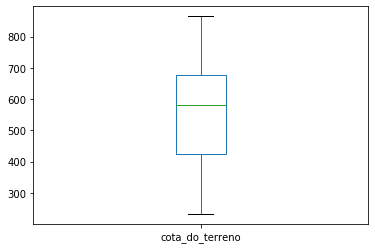

In [17]:
df_litologia['cota_do_terreno'].plot.box()

In [18]:
df_litologia['cota_do_terreno'].describe()

count    1414.000000
mean      557.102546
std       151.354578
min       232.000000
25%       423.250000
50%       582.000000
75%       676.000000
max       865.000000
Name: cota_do_terreno, dtype: float64

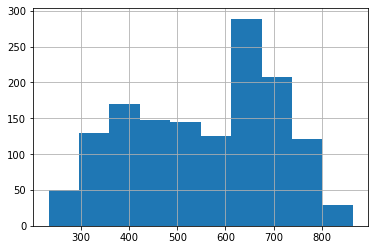

In [19]:
df_litologia['cota_do_terreno'].hist()

Podemos perceber que a maior parte da nossa distribuição de cotas se encontra a 638m acima do nível do mar. Vamos agora georeferenciar estas cotas para nos localizarmos e fazer uma análise mais aprofundada.

Primeiro vamos importar o mapa de municípios de Santa Catarina.

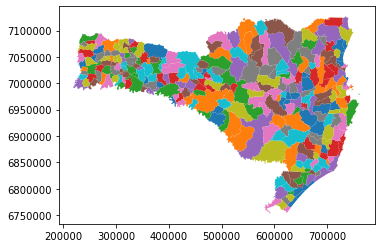

In [3]:
mun_sc = gp.read_file('./gis/42MUE250GC_SIR.shp').set_crs('EPSG:31982') #Municípios_SIRGAS2000_22S.shp
mun_sc.plot(column='NM_MUNICIP')

In [21]:
mun_sc.head()

,NM_MUNICIP,CD_GEOCMU,geometry
0,ABELARDO LUZ,4200101,"POLYGON ((384491.277 7072162.034, 384602.835 7..."
1,ÁGUAS DE CHAPECÓ,4200507,"POLYGON ((308009.469 7017850.213, 308001.888 7..."
2,ÁGUAS FRIAS,4200556,"POLYGON ((320506.100 7031036.955, 320629.652 7..."
3,ALTO BELA VISTA,4200754,"POLYGON ((407065.221 6976057.505, 407279.770 6..."
4,ANCHIETA,4200804,"POLYGON ((276923.059 7062270.825, 275161.329 7..."


Perfeito. Agora iremos criar os pontos com feições em 3D utilizando o geopandas. Utilizaremos como valor de Z o valor da 'cota_do_terreno' menos o valor 'de'. Sabemos previamente que o SIAGAS utiliza SIRGAS2000.

In [22]:
df_litologia['coordenadas'] = [ Point(coords) for coords in zip(df_litologia['utm_lo'],df_litologia['utm_ns'], df_litologia['cota_do_terreno'] - df_litologia['de'])]
df_litologia.head()

,nome,de,ate,litologia,utm_ns,utm_lo,cota_do_terreno,coordenadas
1761,SN_nan_4300015619,0.0,186.0,Basalto,7010189.0,344574.0,504.0,POINT Z (344574 7010189 504)
746,SN_nan_4300004878,0.0,128.0,Basalto,7019845.0,305660.0,335.0,POINT Z (305660 7019845 335)
1585,SN_nan_4300012884,1.0,102.0,Basalto,7019808.0,308525.0,325.0,POINT Z (308525 7019808 324)
1584,SN_nan_4300012884,0.0,1.0,Solo,7019808.0,308525.0,325.0,POINT Z (308525 7019808 325)
138,SN_NORTE GAS BUTANO DISTR. LTDA_4300003933,0.0,100.0,Basalto,7007965.0,369693.0,589.0,POINT Z (369693 7007965 589)


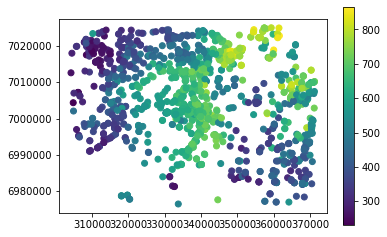

In [23]:
gdf_litologia = gp.GeoDataFrame(df_litologia, geometry='coordenadas').set_crs('EPSG:31982')
gdf_litologia.plot(column='cota_do_terreno', legend=True)

Agora veremos em nosso mapa:

[]

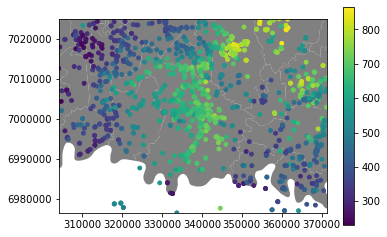

In [24]:
ax = mun_sc.plot(color='grey')

ax.set_ylim([ gdf_litologia['utm_ns'].min(), gdf_litologia['utm_ns'].max() ])
ax.set_xlim([ gdf_litologia['utm_lo'].min(), gdf_litologia['utm_lo'].max() ])

gdf_litologia.plot(ax=ax, markersize=15, column='cota_do_terreno', legend=True)

plt.plot()

Vamos selecionar todos os pontos pertencentes somente a Chapecó.

In [25]:
chapeco = mun_sc[ mun_sc['NM_MUNICIP'] == 'CHAPECÓ' ]
gdf_lit_chap = gp.clip( gdf_litologia.set_crs('EPSG:31982'), chapeco )

[]

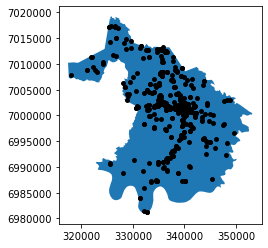

In [26]:
ax = chapeco.plot()

gdf_lit_chap.plot(ax=ax, color='black', markersize=15)

plt.plot()

Agora uma parte bem legal: vamos criar uma malha triangularizada de cada cadamada que obtivemos a partir dos tipos de litologia!

Para conseguirmos triangularizar uma série de pontos, precisamos necessariamente de ao menos três deles. Portanto, temos que verificar o total pontos de cada tipo de litologia.

In [27]:
valores_litologia = df_litologia['litologia'].value_counts()
valores_litologia

Basalto                                1125
Solo                                    223
Solo argiloso                            27
Rochas Intemperizadas e Decompostas      17
Arenito médio                             4
Diabásio                                  4
Arenito fino                              2
Solo areno-argiloso                       2
Cascalho                                  2
Arenito siltoso                           1
Areia conglomerática argilosa             1
Areia média                               1
Arenito silicificado                      1
Riolito                                   1
Carbonatito                               1
Argila                                    1
Brechas                                   1
Name: litologia, dtype: int64

Para este procedimento, vamos apenas remover entradas que possuam quantidade de dados menor que três.

In [28]:
litologias_a_excluir = valores_litologia[ valores_litologia < 3 ].index

for litologia in litologias_a_excluir:
    df_litologia = df_litologia[ df_litologia['litologia'] != litologia ]
    
df_litologia['litologia'].value_counts()

Basalto                                1125
Solo                                    223
Solo argiloso                            27
Rochas Intemperizadas e Decompostas      17
Diabásio                                  4
Arenito médio                             4
Name: litologia, dtype: int64

Bacana. Nossa próxima tarefa é substituir 'Solo argiloso' por 'Solo' e listar as litologias restantes.

In [29]:
df_litologia.loc[ (df_litologia['litologia'] == 'Solo argiloso'),'litologia'] = 'Solo'

tipos_litologias = set( df_litologia['litologia'] )
tipos_litologias

{'Arenito médio',
 'Basalto',
 'Diabásio',
 'Rochas Intemperizadas e Decompostas',
 'Solo'}

Vamos agora selecionar e separar cada tipo de litologia, e criar uma coluna de pontos em formato de lista. Colocaremos esses valores em 'x', 'y' e 'z'.

In [30]:
df_litologia['x'] = df_litologia['coordenadas'].apply( lambda x : x.coords[0][0] )
df_litologia['y'] = df_litologia['coordenadas'].apply( lambda x : x.coords[0][1] )
df_litologia['z'] = df_litologia['coordenadas'].apply( lambda x : x.coords[0][2] )

df_litologia.head()

,nome,de,ate,litologia,utm_ns,utm_lo,cota_do_terreno,coordenadas,x,y,z
1761,SN_nan_4300015619,0.0,186.0,Basalto,7010189.0,344574.0,504.0,POINT Z (344574.000 7010189.000 504.000),344574.0,7010189.0,504.0
746,SN_nan_4300004878,0.0,128.0,Basalto,7019845.0,305660.0,335.0,POINT Z (305660.000 7019845.000 335.000),305660.0,7019845.0,335.0
1585,SN_nan_4300012884,1.0,102.0,Basalto,7019808.0,308525.0,325.0,POINT Z (308525.000 7019808.000 324.000),308525.0,7019808.0,324.0
1584,SN_nan_4300012884,0.0,1.0,Solo,7019808.0,308525.0,325.0,POINT Z (308525.000 7019808.000 325.000),308525.0,7019808.0,325.0
138,SN_NORTE GAS BUTANO DISTR. LTDA_4300003933,0.0,100.0,Basalto,7007965.0,369693.0,589.0,POINT Z (369693.000 7007965.000 589.000),369693.0,7007965.0,589.0


Agora vamos separar cada tipo de litologia e armezenar as coordenadas com tipo vetor numpy em um dicionário chamado litologias.

In [31]:
litologias = {}

for tipo in tipos_litologias:
    litologias[ tipo ] = df_litologia[ df_litologia['litologia'] == tipo ][['x','y','z']].to_numpy()

Finalmente, vamos criar e exibir nossa malha utilizando o PyVista:

In [32]:
#plotter = pv.PlotterITK(notebook=True)
geometrias = {}
for tipo in tipos_litologias:
    nuvem = pv.PolyData( litologias[tipo] )
    superf = nuvem.delaunay_2d()
    geometrias[tipo] = superf
    #plotter.add_mesh(superf, color=None )

#plotter.show()
view(geometries=geometrias)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…